# Imports

In [67]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import GridSearchCV

## some data constants

In [68]:
subjects = 40
photos = 10
samples = subjects * photos
width = 92
length = 112
pixels = 10304

# Load Data

In [69]:
# inisialize a zeros vector to stack features on and an empty labels vector
features = np.zeros((1, pixels))
labels = []

for i in range(1, subjects+1):
    for j in range(1, photos+1):
        img = Image.open(f"data/s{i}/{j}.pgm")
        img = np.asarray(img)
        img = img.reshape(1,-1)
        
        features = np.vstack((features, img))
        labels.append(i)

# drop the initial zeros row
features = features[1:]
labels = np.array(labels)


In [70]:
features.shape

(400, 10304)

In [71]:
labels.shape

(400,)

# View A Few Samples

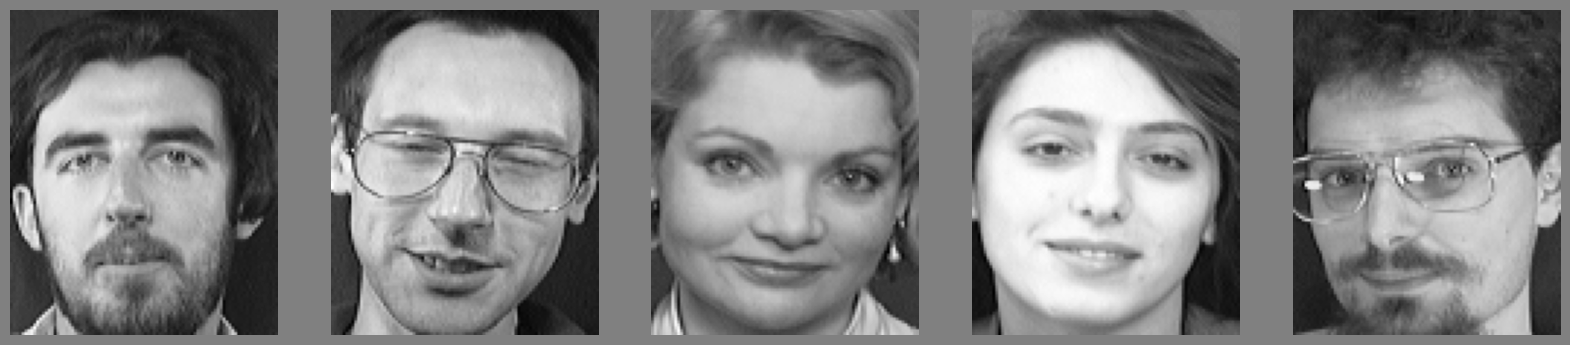

In [72]:
fig, ax = plt.subplots(1, 5, figsize = (20,30))
fig.patch.set_facecolor('grey')

for i in range(5):
    ax[i].imshow(features[np.random.randint(0, 400),:].reshape(length, width), cmap="gray")
    ax[i].axis("off")

# Split The Data

In [73]:
x_train, x_eval, y_train, y_eval = train_test_split(features, labels, test_size=0.5,
                                                     random_state=0, stratify=labels,)

In [74]:
pd.value_counts(y_train)

13    5
34    5
1     5
20    5
32    5
8     5
19    5
28    5
31    5
5     5
38    5
23    5
24    5
37    5
35    5
33    5
7     5
2     5
6     5
26    5
10    5
39    5
30    5
36    5
40    5
29    5
18    5
27    5
4     5
16    5
21    5
25    5
11    5
3     5
17    5
9     5
22    5
15    5
14    5
12    5
Name: count, dtype: int64

# PCA 

In [75]:
# calculate the mean
mean = np.mean(features, axis=0)
mean.shape

(10304,)

In [76]:
# center the data
x_meaned = features - mean
x_meaned.shape

(400, 10304)

In [77]:
# calculate covariance matrix
covariance = np.cov(x_meaned, rowvar=False)
covariance.shape

(10304, 10304)

In [78]:
eig_values, eig_vectors = np.linalg.eigh(covariance)    # calculate eigen values and vectors
eig_values = np.flip(eig_values)                        # flip values to get the descending order
eig_vectors = np.flip(eig_vectors, axis=1)              # flip vectors to get the descending order

In [79]:
# define the alphas we will test
alphas = [0.8, 0.85, 0.9, 0.95]

# calculate sum of eigen values for later calculations
eigen_sum = eig_values.sum()

In [80]:
# calculate the least dimensions that satisfy every alpha
dimensions = []
for alpha in alphas:
    acc = eig_values[0]
    i = 1

    while acc / eigen_sum < alpha:
        acc += eig_values[i]
        i += 1
        
    dimensions.append(i) 


In [81]:
dimensions

[44, 68, 111, 190]

In [82]:
# get the basis for every alpha
basis = [np.array(eig_vectors[:,0:dimension]) for dimension in dimensions]
[base.shape for base in basis]

[(10304, 44), (10304, 68), (10304, 111), (10304, 190)]

In [83]:
# get the projections on every basis
train_meaned = x_train - mean
test_meaned = x_eval - mean
train_projections = [train_meaned @ base for base in basis]
test_projections = [test_meaned @ base for base in basis]

In [84]:
[projection.shape for projection in train_projections]

[(200, 44), (200, 68), (200, 111), (200, 190)]

In [85]:
train_reconstructions = np.array([proj @ base.T + mean for proj,base in zip(train_projections, basis)])

In [86]:
train_reconstructions.shape

(4, 200, 10304)

# Visialize The Eigen Faces 

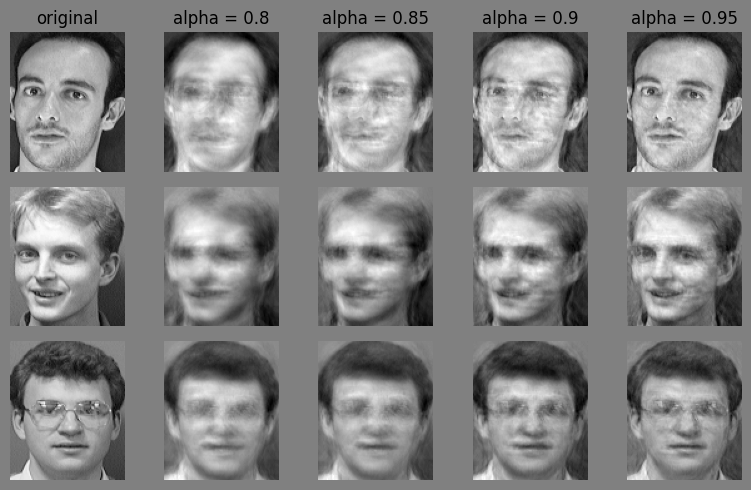

In [87]:
fig, ax = plt.subplots(3, 5, figsize = (8,5))
fig.patch.set_color("grey")
ax[0][0].set_title(f"original")
for i in range(1,5):
    ax[0][i].set_title(f"alpha = {alphas[i-1]}")

for i in range(3):
    ind = np.random.randint(0, 200)
    ax[i][0].imshow(x_train[ind,:].reshape(length, width), cmap="gray")
    ax[i][0].axis("off")

    for j in range(1, 5):
        img = train_reconstructions[j-1][ind]

        ax[i][j].imshow(img.reshape(length, width), cmap="gray")
        ax[i][j].axis("off")
fig.tight_layout()

# Train the model

In [88]:
model = KNN()

params = {
    "n_neighbors": list(range(1,10,2))
}

model_cv = GridSearchCV(model, param_grid=params, cv=5,
                       return_train_score=True, scoring="accuracy")

In [89]:
test_accuracies = []
for i, proj in enumerate(train_projections):
    model_cv.fit(proj, y_train)
    results = pd.DataFrame(model_cv.cv_results_)
    knn_selected_results = results[["param_n_neighbors", "mean_test_score", "mean_train_score"]]

    pred = model_cv.best_estimator_.predict(test_projections[i])
    acc = np.mean(pred == y_eval)
    test_accuracies.append(acc)

    print(f"alpha: {alphas[i]}\n", f"best fit test accuracy = {acc}\n", knn_selected_results, "\n\n", sep="")


alpha: 0.8
best fit test accuracy = 0.92
  param_n_neighbors  mean_test_score  mean_train_score
0                 1            0.935           1.00000
1                 3            0.855           0.93375
2                 5            0.780           0.87375
3                 7            0.720           0.80125
4                 9            0.670           0.73875


alpha: 0.85
best fit test accuracy = 0.925
  param_n_neighbors  mean_test_score  mean_train_score
0                 1            0.930           1.00000
1                 3            0.860           0.93875
2                 5            0.770           0.86250
3                 7            0.720           0.79750
4                 9            0.675           0.73125


alpha: 0.9
best fit test accuracy = 0.925
  param_n_neighbors  mean_test_score  mean_train_score
0                 1            0.930           1.00000
1                 3            0.860           0.92875
2                 5            0.740         

Text(0, 0.5, 'test accuracy')

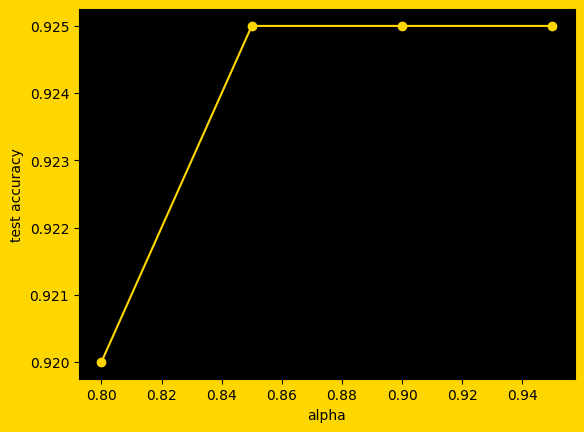

In [90]:
fig = plt.figure()
fig.patch.set_facecolor('gold')

ax = plt.axes()
ax.set_facecolor("black")


plt.plot(alphas, test_accuracies, linestyle='-', marker='o', color='gold')
plt.xlabel("alpha")
plt.ylabel("test accuracy")

# Try 70-30 train-test split

In [96]:
x_train, x_eval, y_train, y_eval = train_test_split(features, labels, train_size=0.7,
                                                     random_state=0, stratify=labels,)

In [97]:
pd.value_counts(y_train)

32    7
27    7
35    7
39    7
36    7
11    7
34    7
40    7
17    7
12    7
29    7
1     7
22    7
24    7
15    7
18    7
19    7
9     7
16    7
31    7
30    7
21    7
8     7
10    7
6     7
38    7
26    7
14    7
13    7
33    7
23    7
2     7
25    7
37    7
7     7
4     7
28    7
5     7
3     7
20    7
Name: count, dtype: int64

In [98]:
# get the projections on every basis
train_meaned = x_train - mean
test_meaned = x_eval - mean
train_projections = [train_meaned @ base for base in basis]
test_projections = [test_meaned @ base for base in basis]

In [99]:
model = KNN()

params = {
    "n_neighbors": list(range(1,10,2))
}

model_cv = GridSearchCV(model, param_grid=params, cv=5,
                       return_train_score=True, scoring="accuracy")

In [100]:
test_accuracies = []
for i, proj in enumerate(train_projections):
    model_cv.fit(proj, y_train)
    results = pd.DataFrame(model_cv.cv_results_)
    knn_selected_results = results[["param_n_neighbors", "mean_test_score", "mean_train_score"]]

    pred = model_cv.best_estimator_.predict(test_projections[i])
    acc = np.mean(pred == y_eval)
    test_accuracies.append(acc)

    print(f"alpha: {alphas[i]}\n", f"best fit test accuracy = {acc}\n", knn_selected_results, "\n\n", sep="")

alpha: 0.8
best fit test accuracy = 0.9583333333333334
  param_n_neighbors  mean_test_score  mean_train_score
0                 1         0.953571          1.000000
1                 3         0.903571          0.964286
2                 5         0.860714          0.923214
3                 7         0.785714          0.872321
4                 9         0.732143          0.818750


alpha: 0.85
best fit test accuracy = 0.9583333333333334
  param_n_neighbors  mean_test_score  mean_train_score
0                 1         0.950000          1.000000
1                 3         0.907143          0.968750
2                 5         0.850000          0.916071
3                 7         0.785714          0.866071
4                 9         0.717857          0.808036


alpha: 0.9
best fit test accuracy = 0.9666666666666667
  param_n_neighbors  mean_test_score  mean_train_score
0                 1         0.960714          1.000000
1                 3         0.885714          0.964286
2    